In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
from tqdm.notebook import tqdm  

plt.style.use("ggplot")
%config InlineBackend.figure_formats = ['svg']

I'll use a single layer perceptron binary classifier to learn a 2D nonlinear function. In PyTorch models inherit from `nn.Module`, and must implement the `forward` method. I used `nn.Sequential` here because the architecture is a simple sequence of layers.

In [2]:
class LinearNet(nn.Module):
    def __init__(self,n_in,n_units):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_in,n_units),
            nn.ReLU(),
            nn.Linear(n_units,1),
        )
        
    def forward(self,x):
        return self.model(x)

In [3]:
net = LinearNet(2,16)

Datasets inherit from `data.Dataset`, and must implement `__len__` and `__getitem__`.

In [4]:
class QuadrantDataset(data.Dataset):
    
    def __init__(self,n_samples):
        
        self.size = n_samples
        
        self.data = torch.rand((n_samples,2)) - 0.5
        
        self.label = self.data[:,0]*self.data[:,1] > 0
        
    def __len__(self):
        return self.size
    
    def __getitem__(self,idx):
        return self.data[idx],self.label[idx]

In [5]:
train_dataset = QuadrantDataset(5000)

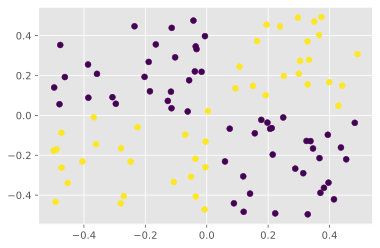

In [6]:
plt.scatter(train_dataset.data[:100,0],train_dataset.data[:100,1],c=train_dataset.label[:100])

In [7]:
batch_size = 16
train_data_loader = data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

As loss function I'm using `BCEWithLogitsLoss`, which combines a sigmoid and cross-entropy. Notice that `LinearNet` returns logits.

In [8]:
loss_fn = nn.BCEWithLogitsLoss() # combine sigmoid and BCE

In [9]:
optimizer = torch.optim.Adadelta(net.parameters())

In [10]:
test_dataset = QuadrantDataset(100) # validation set
test_dataloader = data.DataLoader(test_dataset,batch_size=batch_size)

Training loop the PyTorch way:
1. Compute predictions
2. Compute loss
3. Zero out gradients (by default they are accumulated)
4. Backprop
5. Take a step with the optimizer

In [11]:
num_epochs = 11

loss_mean = torch.Tensor(num_epochs)
loss_std = torch.Tensor(num_epochs)
test_acc = torch.Tensor(num_epochs)

for epoch in tqdm(range(num_epochs)):
    
    losses = torch.Tensor(len(train_data_loader))

    for i,(X,y) in enumerate(train_data_loader):
        preds = net(X).squeeze()
        
        loss = loss_fn(preds,y.to(torch.float32))
        
        optimizer.zero_grad() # knows at what point in the minibatch we are
        loss.backward()
        optimizer.step()
        
        
        losses[i] = loss
        
    correct = 0
    total = 0

    with torch.no_grad():
        for X,y in test_dataloader:
            preds = net(X).squeeze() > 0.5 # threshold it to turn it into labels
            total += len(preds)
            correct += torch.sum(y == preds)

    test_acc[epoch] = correct/total
    loss_mean[epoch] = torch.mean(losses).item()
    loss_std[epoch] = torch.std(losses).item()

  0%|          | 0/11 [00:00<?, ?it/s]

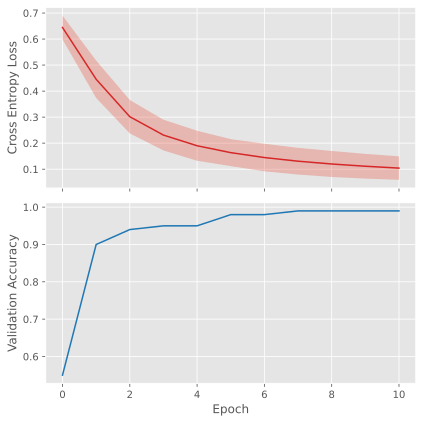

In [12]:
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax[0].plot(range(num_epochs),loss_mean,color="tab:red")
ax[0].fill_between(range(num_epochs),y1=loss_mean - loss_std, y2=loss_mean + loss_std,alpha=0.3)
ax[0].set_ylabel("Cross Entropy Loss")

ax[1].plot(range(num_epochs),test_acc,color="tab:blue")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Accuracy")

fig.tight_layout()